In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pmesh.pm import ParticleMesh as PM
from nbodykit.lab import BigFileCatalog, BigFileMesh, FFTPower
import os, sys

Populating the interactive namespace from numpy and matplotlib


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/nbodykit/extern/docrep.py:412: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents(s)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/nbodykit/extern/docrep.py:341: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))


In [99]:
##Setup a mock box, throw in a random particle to estimate its force at the the grid points

bs = 100
nc = 128
pm = PM(BoxSize=bs, Nmesh=[nc]*3)
grid = pm.generate_uniform_particle_grid(shift=0)

ppos = (np.random.uniform(size=3)*bs).reshape(1, 3)
print(ppos)
mesh = pm.paint(ppos)/pm.Nmesh.prod()

nrandom = int(1e5)
rpos = (np.random.uniform(size=nrandom*3)*bs).reshape(nrandom, 3)

rr = ((rpos - ppos)**2).sum(axis=1)**0.5


[[42.97815681 27.95266908 61.17556106]]


In [100]:
def laplace(k, v):
    kk = sum(ki ** 2 for ki in k)
    mask = (kk == 0).nonzero()
    kk[mask] = 1
    b = v / kk
    b[mask] = 0
    return b


def gradient(dir, order=0):
    if order == 0:
        def kernel(k, v):
            # clear the nyquist to ensure field is real                                                                                                                             
            mask = v.i[dir] != v.Nmesh[dir] // 2
            return v * (1j * k[dir]) * mask
    if order == 1:
        def kernel(k, v):
            cellsize = (v.BoxSize[dir] / v.Nmesh[dir])
            w = k[dir] * cellsize

            a = 1 / (6.0 * cellsize) * (8 * numpy.sin(w) - numpy.sin(2 * w))
            # a is already zero at the nyquist to ensure field is real                                                                                                              
            return v * (1j * a)
    return kernel





def force_batch(x, delta_k, split=0, factor=1):
    """ like long range, but x is a list of positions """
    # different from fastpm in using regular gradient kernel and changed to singple processing computation

    f = numpy.empty_like(x)

    pot_k = delta_k.apply(laplace)

    for d in range(delta_k.ndim):
        force_d = pot_k.apply(gradient(d, order=1)) \
                  .c2r(out=Ellipsis)
#         for xi, fi in zip(x, f):
#             print(xi, fi)
#             force_d.readout(xi, out=fi[..., d])
        force_d.readout(x, out=f[..., d])

    return f


In [101]:
meshk = mesh.r2c()
forcev = force_batch(rpos, meshk)
force = (forcev**2).sum(axis=1)**0.5

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


[]

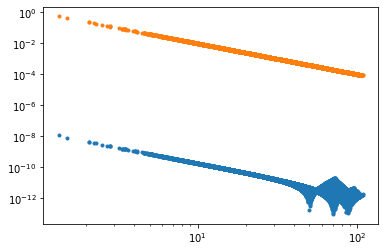

In [102]:
##Plot the computed force at the grid points and expected 1/r^2
plt.plot(rr, force, '.')
plt.plot(rr, 1/rr**2, '.')
plt.loglog()

# Splitting

In [103]:
def fknlongrange(r_split):
    if r_split != 0:
        def kernel(k, v):
            kk = sum(ki ** 2 for ki in k)
            return v * numpy.exp(-kk * r_split**2)
    else:
        def kernel(k, v):
            return v
    return kernel


def fknsmallrange(r_split):
    if r_split != 0:
        def kernel(k, v):
            kk = sum(ki ** 2 for ki in k)
            return v * (1-numpy.exp(-kk * r_split**2))
    else:
        def kernel(k, v):
            return v
    return kernel



def longrange_batch(x, delta_k, split, factor=1):
    """ like long range, but x is a list of positions """
    # different from fastpm in using regular gradient kernel and changed to singple processing computation

    f = numpy.empty_like(x)

    pot_k = delta_k.apply(laplace) \
                  .apply(fknlongrange(split), out=Ellipsis)

    for d in range(delta_k.ndim):
        force_d = pot_k.apply(gradient(d, order=1)) \
                  .c2r(out=Ellipsis)
        force_d.readout(x, out=f[..., d])

    return f


def smallrange_batch(x, delta_k, split, factor=1):
    """ like long range, but x is a list of positions """
    # different from fastpm in using regular gradient kernel and changed to singple processing computation

    f = numpy.empty_like(x)

    pot_k = delta_k.apply(laplace) \
                  .apply(fknsmallrange(split), out=Ellipsis)

    for d in range(delta_k.ndim):
        force_d = pot_k.apply(gradient(d, order=1)) \
                  .c2r(out=Ellipsis)
        force_d.readout(x, out=f[..., d])

    return f


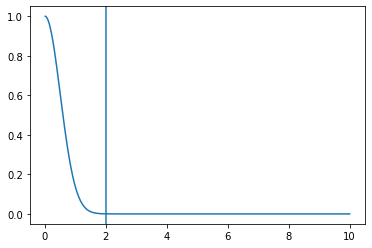

In [104]:
kk = np.logspace(-2, 1, 1000)
rc = 1*2
plt.plot(kk, np.exp(-kk**2*rc))
plt.axvline(rc)

In [105]:
pmlong = PM(BoxSize=bs, Nmesh=[32]*3)
pmsmall = PM(BoxSize=bs, Nmesh=[nc]*3)

meshlong = pmlong.paint(ppos)/pmlong.Nmesh.prod()
meshsmall = pmsmall.paint(ppos)/pmlong.Nmesh.prod()

rsplit = 1*bs/nc*32
print(rsplit)
forcelongv = longrange_batch(rpos, meshlong.r2c(), split=rsplit)
forcelong = (forcelongv**2).sum(axis=1)**0.5

forcesmallv = smallrange_batch(rpos, meshsmall.r2c(), split=rsplit)
forcesmall = (forcesmallv**2).sum(axis=1)**0.5

25.0


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  after removing the cwd from sys.path.
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  from ipykernel import kernelapp as app


In [106]:
def plotrf(rr, ff, bins=100, lscale=True):
    if lscale: rr = np.log(rr)
    n, x = np.histogram(rr, bins=bins)
    w, _ = np.histogram(rr, bins=bins, weights=ff)
    w2, _ = np.histogram(rr, bins=bins, weights=ff**2)
    err = (w**2 - w2)**0.5
    if lscale: x = np.exp(x)
    return x[:-1], w/n #, err

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


[]

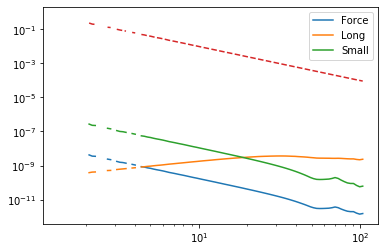

In [107]:
##Plot the computed force at the grid points and expected 1/r^2

plt.plot(*plotrf(rr, force), label='Force')
plt.plot(*plotrf(rr, forcelong), label='Long')
plt.plot(*plotrf(rr, forcesmall), label='Small')
plt.plot(*plotrf(rr, 1/rr**2), '--')
plt.legend()
# plt.plot(rr, force, '.')
# plt.plot(rr, forcelong, '.')
# plt.plot(rr, forcesmall, '.')
# # plt.plot(rr, 1/rr**2, '.')
plt.loglog()

In [70]:
np.histogram(rr)

(array([  784,  4216, 10336, 16969, 20797, 20429, 16421,  7707,  2089,
          252]), array([  1.87117337,  12.31642156,  22.76166976,  33.20691795,
         43.65216615,  54.09741434,  64.54266254,  74.98791073,
         85.43315893,  95.87840712, 106.32365532]))